# Trim the P wave window

Trim the P wave window to evaluate the half maximum pulse width.
This notebook is updated from `01_Introduction_plot_gougerepeatingevents_v2.ipynb` for the section of the trimming.

2024.11.3 Kurama Okubo

- 2024.11.20 update high-pass filter two-way `sosfiltfilt`at 0.06->0.1MHz
- 2024.11.25 Skipped the high-pass filter to make an option of either the detrend or the filtering in the following notebooks. Extended the trimming window length.

In [145]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings
import time
import pickle 
import seaborn as sns
from scipy.optimize import minimize
import mpmath as mp

from obspy.signal.cross_correlation import correlate, xcorr_max

from obspy.core.utcdatetime import UTCDateTime    

%load_ext autoreload
%autoreload 2

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
UTCDateTime.DEFAULT_PRECISION = 8 # increase the time precision


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
# channel table
channel_finame = '../../Others/AEchanneltable/AEsensorlocation_onFB03_table.csv'

# input datadir
data_inputdir = "../../SourceInvFit/data/07_DATA_MTinversion" # for the tiny events 

# select balldrop calibration model
balldrop_model=4 # 2 for the model only with SiTj, 4 for the SiTjbeta

if balldrop_model==4:
    aperturecorrection=True
elif balldrop_model==2:
    aperturecorrection=False
else:
    aperturecorrection=False
    
# Path for event data
datadir = f"../../SourceInvFit/data/06_assemble_gf_model{balldrop_model}"


In [147]:
dataoutdir = "../data/02_trim_Pwave"
if not os.path.exists(dataoutdir):
    os.makedirs(dataoutdir)

In [148]:
figdir = "../figure/debug_02_trim_Pwave"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [149]:
# Read Channel Index
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
AEsensors = list(channel_loc.keys())
# channel_loc

# Load the onset time of the data

In [150]:
gougepatch_id = "G3" # to set output filename

sensor_id = 7 # 7,8,22,23 loop with the sensors
repeated_sensor = f"OL{sensor_id:02d}"


In [151]:
df_onset = pd.read_csv(f"../data/01_plot_gougeevents/P_repicked_onset_time_G3_{repeated_sensor}.csv", index_col=0)
datacases = list(df_onset.index)
df_onset.head()

,onset_npt,sensor,onset_t[ms],onset_d_ref[mm]
fb03-087__0129,301,OL07,0.0201,124.62
fb03-087__0088,299,OL07,0.0199,123.38
fb03-087__0031,303,OL07,0.0203,125.86
fb03-087__0020,299,OL07,0.0199,123.38
fb03-087__0027,301,OL07,0.0201,124.62


# Load best-fit source parameters
Loading the source parameters estimated by the waveform fitting.

In [152]:
# Path to the best fit source parameters
bestfitsourceparam_finame = f"../../SourceInvFit/data/datacsv/gridsearch_bestparam_M0andTR_fb03-087.csv"

df_bestparam = pd.read_csv(bestfitsourceparam_finame, index_col=0) # from waveform inversion
datacases = df_bestparam.index
df_bestparam.head()

,VR_P_best,M0_best,TR_best,rake_best
fb03-087__0004,0.89,0.57,3.3,0
fb03-087__0009,0.73,0.05,3.1,0
fb03-087__0018,0.87,0.61,3.5,0
fb03-087__0019,0.79,0.05,3.1,0
fb03-087__0020,0.89,0.77,3.3,0


# Load the waveforms

In [153]:
st_repeat_raw = Stream()
st_repeat = Stream()

for datacase in datacases:
# datacase = datacases[4] # We repeated running the notebook with selecting the datacase to complete the grid search for all the events.
    # print(f"start processing {repeated_sensor} event {datacase}.")

    # load event trace
    st_event = read(datadir + "/{}_AEwaveform.pickle".format(datacase)) # this contains observation and green's function within a thresholded distance
    tr_obs_raw = st_event.select(station=repeated_sensor, location="raw")[0]
    tr_obs_afterremovalresp = st_event.select(station=repeated_sensor, location="stage1")[0] # after the correction of gain
    st_repeat_raw.append(tr_obs_raw)
    st_repeat.append(tr_obs_afterremovalresp)
    


## plot waveforms

In [154]:
# compute source distance
dist_all = []
for tr in st_repeat:
    dist_all.append(tr.stats.dist)

dist = np.mean(dist_all)
dist

120.34747238352215

In [155]:
with open(data_inputdir+"/GridSearch_param_{}_balldropmodel{}.pickle".format(datacases[0], balldrop_model),"rb") as fo:
    param = pickle.load(fo)


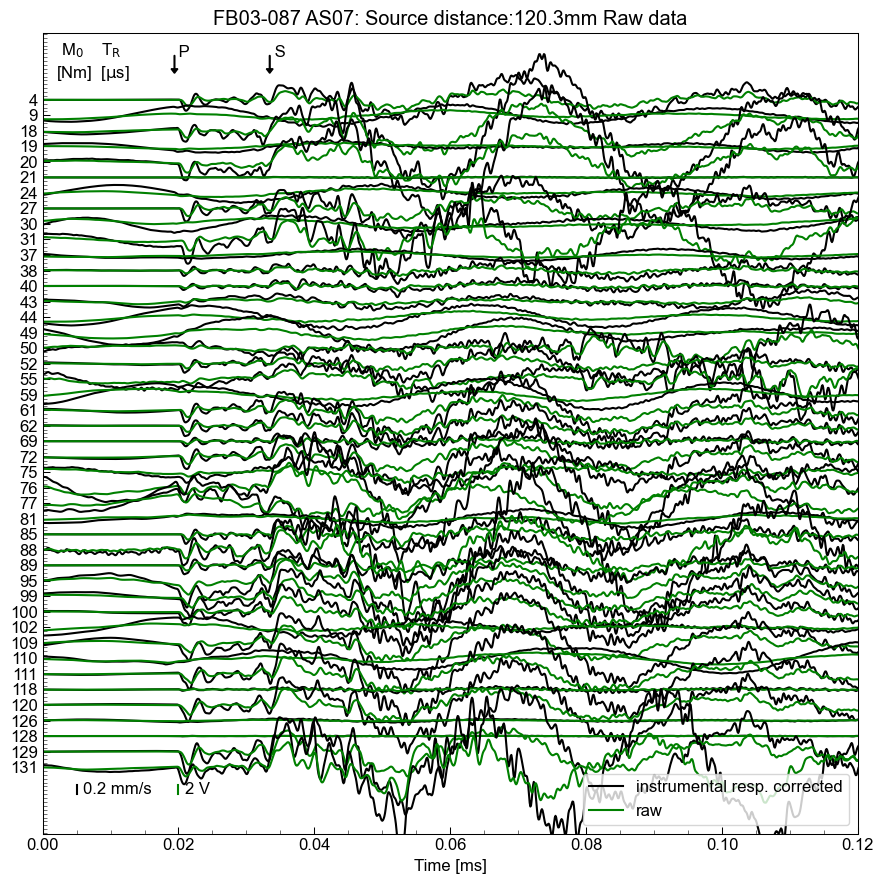

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))


selected_sensor = st_repeat[0].stats.station
tvec = st_repeat[0].times()*1e3


# compute P and S arrival
tp = dist/param['cp']
ts = dist/param['cs']

yshift = 0
del_yshift = 7e-3 #4e-3
ampnorm = 0.05 # for tiny events #0.1 #12
yspan = 0# 1.2e-3
expr_id = datacases[0].split('__')[0]

pretrigger = st_repeat[0].stats.pretrigger # [ms]
ytickloc = []
yticklabel = []

# Plot repeated events
raw_ampnorm = 5e2

for i, datacase in enumerate(datacases):
    # i = 4
    gougeevent_id = int(datacase.split("__")[1])
    tr_ind = [x.stats.dataindex[6:] for x in st_repeat].index(datacase)
    tr_obs = st_repeat[tr_ind]
    tr_obs_raw = st_repeat_raw[tr_ind]
    assert(tr_obs.stats.dataindex[6:]==datacase) # check if the correct datacase is selected
    assert(tr_obs_raw.stats.dataindex[6:]==datacase) # check if the correct datacase is selected
    ytickloc.append(-yshift)
    yticklabel.append(f"{gougeevent_id:g}")
    h1 = ax.plot(tvec-pretrigger, (tr_obs.data/ampnorm) - yshift, "k-", label="instrumental resp. corrected")
    h2 = ax.plot(tvec-pretrigger, (tr_obs_raw.data/raw_ampnorm) - yshift, "g-", label="Raw")
    # ax.plot(tvec-pretrigger+dt_shift_p, (tr_syn.data/ampnorm) - yshift - yspan, "r-", lw=1)
    yshift = yshift + del_yshift

# Annotate estimated source parameters
annot_x = 0.0027
annot_x_text = 0.002
annot_y = -0.0019

# for i, datacase in enumerate(datacases):
#     # print(datacase)
#     M0_best = df_bestparam.loc[datacase]["M0_best"]
#     TR_best = df_bestparam.loc[datacase]["TR_best"]
#     ax.text(annot_x_text, ytickloc[i]+annot_y, r"{:.2f},  {:.1f}".format(M0_best, TR_best), ha="left")
    
annot_txt = [r"M$_{\mathrm{0}}$", r"T$_{\mathrm{R}}$"]
annot_txt_unit = ["[Nm]", r"[$\mathrm{\mu}$s]"]
ax.text(annot_x, ytickloc[0]+0.02, "{}    {}".format(*annot_txt), ha="left")
ax.text(annot_x-0.0008, ytickloc[0]+0.01, "{}  {}".format(*annot_txt_unit), ha="left")

# annotate the scale of velocity
scale_x = 0.005
scale_y = -(ytickloc[-1]-0.01)
scale_amplitude = 0.2e-3 #[mm/s]
ax.plot([scale_x, scale_x], np.array([-scale_amplitude/2, +scale_amplitude/2])/ampnorm-scale_y, "k-");
ax.text(scale_x+0.001, -(scale_amplitude/2/ampnorm)-scale_y, f"{scale_amplitude*1e3:.1f} mm/s" )

# annotate the scale of voltage
scale_x2 = 0.02
scale_y2 = -(ytickloc[-1]-0.01)
scale_amplitude2 = 2.0 #[V]
ax.plot([scale_x2, scale_x2], np.array([-scale_amplitude2/2, +scale_amplitude2/2])/raw_ampnorm-scale_y2, "g-");
ax.text(scale_x2+0.001, -(scale_amplitude2/2/raw_ampnorm)-scale_y2, f"{scale_amplitude2:.0f} V" )

# annotate p and s arrival
arrow_y = 0.02
ax.arrow(tp, arrow_y, 0, -8e-3, width=1e-4, length_includes_head=True, head_length=2e-3,head_width=1e-3, color='k')
ax.arrow(ts, arrow_y, 0, -8e-3, width=1e-4, length_includes_head=True, head_length=2e-3,head_width=1e-3, color='k')
ax.text(tp, arrow_y-0.6e-3, " P", ha="left")
ax.text(ts, arrow_y-0.6e-3, " S", ha="left")

# # plot stacked trace
# yshift = yshift + 0.5*del_yshift
# ax.plot(tvec-pretrigger, (tr_stack.data/ampnorm) - yshift, "k-", lw=2)
# ytickloc.append(-yshift)
# yticklabel.append("Stacked")

# decoration of figure
ax.set_xlim([0.0, 0.12])
ax.set_ylim([ytickloc[-1]-0.03, ytickloc[0]+0.03])

ax.set_xlabel("Time [ms]")

ax.set_yticks(np.round(ytickloc, 3))
ax.set_yticklabels(yticklabel)

title_str = f"FB03-087 AS{selected_sensor[2:]}: Source distance:{dist:.1f}mm Raw data"

ax.legend(["instrumental resp. corrected", "raw"], loc=4)
ax.set_title(title_str)

fig.tight_layout()

# plt.savefig(figdir + "/waveform_repeated_event_{}_{}_raw_afterinstrumentalcorrection_all.png".format(gougepatch_id, repeated_sensor), dpi=300)
# plt.savefig(figdir + "/waveform_repeated_event_{}_{}_raw_afterinstrumentalcorrection_all.eps".format(gougepatch_id, repeated_sensor))


In [157]:
print(f"Number of events: {len(datacases)}.")

Number of events: 44.


In [158]:
datacase = datacases[9]
gougeevent_id = 43
tr_ind = [x.stats.dataindex[6:] for x in st_repeat].index(datacase)
tr_obs = st_repeat[tr_ind]
tr_obs_raw = st_repeat_raw[tr_ind]

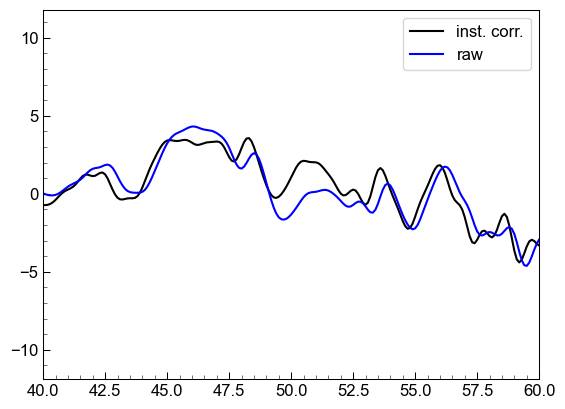

In [159]:
plt.plot(tr_obs.times()*1e6, tr_obs.data*5e3, "k", label="inst. corr.")
plt.plot(tr_obs.times()*1e6, tr_obs_raw.data, "b", label="raw")
# plt.xlim([13, 120])
plt.xlim([40, 60])
plt.legend(loc=0)

# Trim the P wave window

We trim the P wave window using the repicked P onset.


## Compute displacement pulse
To evaluate the moment rate function (far-field displacement pulse) to confirm the non-self-similarity, we compute the displacement pulse.

The far-field moment rate function can be writen as follows:

$$ \dot{M_0}\left(t - \dfrac{r}{\alpha}\right)  = 4 \pi r \rho \alpha^3 \dfrac{u_{in}^P(\mathbf{x}, t)}{ {A}_{in}^{FP} },  $$
where $u_{in}^P(\mathbf{x}, t)$ is the radial component of the incident P wave and $ {A}_{in}^{FP} $ is the radial component of the radiation pattern such as

$$ {A}_{in}^{FP} = \sin 2\theta \cos \phi, $$

where $\theta$ and $\phi$ are the dip and azimuth from source to receiver, respectively.



The amplitude of $\mathbf{u}^P(\mathbf{x}, t)$ is obtained by the reflection coefficient (see Aki and Richards Q5.6) such as

$$  u_{in}^P(\mathbf{x}, t) = \dfrac{\left( \frac{1}{\beta^2}-2p^2 \right)^2 + 4 p^2 \frac{\cos i}{\alpha} \frac{\cos j}{\beta}}{\frac{-2\alpha}{\beta^2} \frac{\cos i}{\alpha} \left( \frac{1}{\beta^2}-2p^2 \right) } u_z(\mathbf{x}, t)$$ 

The incident angle $i$ meets the ray parameter

$$ p = \dfrac{\sin i}{\alpha} = \dfrac{\sin j}{\beta}. $$

Therefore,

$$ \cos i = \sqrt{1-(p\alpha)^2} $$
$$ \cos j = \sqrt{1-(p\beta)^2} $$


Hence, the coefficient to convert from displacement to moment rate function is:

$$\dfrac{\dot{M_0}\left(t - \dfrac{r}{\alpha}\right)}{u_z(\mathbf{x}, t)} = 4 \pi r \rho \alpha^3 \dfrac{1}{| {A}_{in}^{FP} |} \dfrac{\left( \frac{1}{\beta^2}-2p^2 \right)^2 + 4 p^2 \frac{\cos i}{\alpha} \frac{\cos j}{\beta}}{\frac{-2\alpha}{\beta^2} \frac{\cos i}{\alpha} \left( \frac{1}{\beta^2}-2p^2 \right) } $$

We take the absolute value of the coefficient as it is negative, showing the negative direction outward of the free surface.

In [160]:
def compute_uz2Mdot_coef(alpha, beta, r_dist, inc_P, rho, dip, azimuth):
    """
    Compute the coefficient to convert the z displacement to moment rate function
    """
    # Radiation pattern
    p_slowness = np.sin(np.deg2rad(inc_P))/alpha
    cos_i = np.cos(np.deg2rad(inc_P))
    cos_j = np.sqrt(1-(p_slowness*beta)**2)
    AFP = compute_AFP(dip, azimuth)
    # print(cos_i, cos_j, AFP)
    
    C1 = 4 * np.pi * r_dist * rho * alpha**3 
    CA = (1/beta**2) - 2*p_slowness**2
    C2 = CA**2 + 4*p_slowness**2 * (cos_i/alpha) * (cos_j/beta)
    C3 = (-2*alpha/(beta**2)) * (cos_i/alpha) * CA
    
    # print( (-2*alpha/(beta**2)), CA, (cos_i/alpha))
    
    return (C1 * C2) / (AFP * C3)
    
def compute_AFP(dip, azimuth):
    # dip is from the vertical direction and azimuth is from the shear direction
    return np.abs(np.sin(2*np.deg2rad(dip)) * np.cos(np.deg2rad(azimuth)))



In [161]:
alpha = param['cp'] # [m/s]
beta = param['cs'] # [m/s]
rho = 2980 # [kg/m^3]

r_dist = dist * 1e-3 #[mm] -> [m]

## compute orientations
The orientations were computed in `SourceInvFit/code/04_AE_convert_to_isoparametric_coordinate.ipynb`.

In [162]:
df_iso_all = pd.read_csv("../../SourceInvFit/data/datacsv/AEevents_isocoord.csv", index_col=0)

In [163]:
r_dist

0.12034747238352214

In [164]:
df_iso_all_station = df_iso_all[df_iso_all["OL"]==repeated_sensor].copy()
df_iso_all_station.head()

,OL,datacase,xs,ys,zs,xi,eta,zeta,xi1,eta1,zeta1,incidentangle,azimuth,rlen_sourcedist,llen
OL07__fb03-087__0004,OL07,fb03-087__0004,1.66,0.05,0.07,1.7475,0.00505,0,0.0875,-0.04495,0,68.142134,62.809787,0.120734,0.098370
OL07__fb03-087__0009,OL07,fb03-087__0009,1.66,0.05,0.07,1.7425,0.00375,0,0.0825,-0.04625,0,66.854879,60.724746,0.117666,0.094580
OL07__fb03-087__0018,OL07,fb03-087__0018,1.66,0.05,0.07,1.7460,0.00375,0,0.0860,-0.04625,0,67.359469,61.729050,0.120146,0.097648
OL07__fb03-087__0019,OL07,fb03-087__0019,1.66,0.05,0.07,1.7425,0.00300,0,0.0825,-0.04700,0,66.519915,60.329966,0.117963,0.094949
OL07__fb03-087__0020,OL07,fb03-087__0020,1.66,0.05,0.07,1.7460,0.00325,0,0.0860,-0.04675,0,67.139755,61.471291,0.120339,0.097885


In [165]:
incidentangle_mean = df_iso_all_station["incidentangle"].mean()

# update 2024.08.23
# the azimuth in the datasheet is computed as `np.rad2deg(np.arctan2(xi1, np.abs(eta1)))` in 04_AE_convert_to_isoparametric_coordinate.ipynb
# Therefore, this is backazimuth from the sensor to source. 
# Here we convert the azimuth from source to sensor


if  df_iso_all[df_iso_all["OL"]==f"{repeated_sensor}"]["ys"].values[0] > 0:
    # south side sensors from 1 to 16
    azimuth_mean = 90 + df_iso_all_station["azimuth"].mean() # convert clockwise from shear direction (Aki & Richards, Fig. 4.4)
    
else:
    # north side sensors from 17 to 32
    azimuth_mean = - (90 - df_iso_all_station["azimuth"].mean()) # the north and south are flipped the coordinates
    
## DEBUG for azimuth correction to optimize the amplitude estimation
## We confirmed the azimuth works 
### debug_azimuth_correction = +30.0 # 
### azimuth -= debug_azimuth_correction

# compute dip
df_iso_all_station.loc[:, "dip"] =  df_iso_all_station.apply(lambda x: np.rad2deg(np.arccos(x.zs/x.rlen_sourcedist)), axis=1)
dip_mean=df_iso_all_station["dip"].mean()
print(f"sensor {repeated_sensor}: {incidentangle_mean:.2f}, {azimuth_mean:.2f}, {dip_mean:.2f}")


sensor OL07: 66.99, 151.26, 54.42


In [166]:
# quick double check of orientations
inc_tmp = np.rad2deg(np.arccos(0.05/r_dist))
axi_tmp = 90-np.rad2deg(np.arccos(0.05/0.17))

print(f"inc_tmp {inc_tmp:.2f} azi_tmp {axi_tmp:.2f}") # the sign of azimuch does not matter

inc_tmp 65.45 azi_tmp 17.10


In [167]:
# check radiation pattern
dip_vec = np.linspace(0, 360, 201)
azi_vec = [0, azimuth_mean, 85]
Nazi = len(azi_vec)

AFP_tmp = np.zeros((len(dip_vec), Nazi))
for i, dd in enumerate(dip_vec):
    for j, aa in enumerate(azi_vec):
        AFP_tmp[i, j] = compute_AFP(dd, aa)

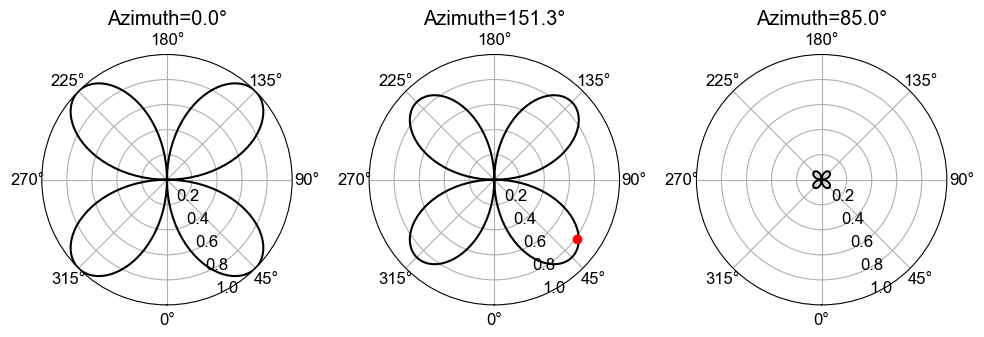

In [168]:
fig, axs = plt.subplots(1, Nazi, figsize = (10, 7), subplot_kw={'projection': 'polar'})

for i, ax in enumerate(axs):
    ax.plot(np.deg2rad(dip_vec), AFP_tmp[:, i], "k-")
    if i == 1:
        # plot sensor location
        dip_sensorind = np.where(dip_vec>dip_mean)[0][0]
        ax.plot(np.deg2rad(dip_mean), AFP_tmp[dip_sensorind, i], "ro")
                         
    ax.set_theta_zero_location("S")
    ax.set_rlim(0, 1)
    ax.set_title(f"Azimuth={azi_vec[i]:.1f}°")

    
fig.tight_layout()

plt.savefig(figdir + f"/check_radiationpattern_{gougepatch_id}_{repeated_sensor}.png", dpi=80)


The radiation patterns above show the vertical cross section at given aziumth on the simulated fault.

In [169]:
# Compute coefficient
print("alpha {:.1f}m/s, beta {:.1f}m/s,  r_dist {:.4f}m, incident angle {:.2f}°,  density {:.1f}kg/m3,  dip {:.1f}°,  azimuth {:.1f}°".format(alpha, beta, r_dist, incidentangle_mean, rho, dip_mean, azimuth_mean))
k_M0uz_mean = np.abs(compute_uz2Mdot_coef(alpha, beta, r_dist, incidentangle_mean, rho, dip_mean, azimuth_mean))

alpha 6200.0m/s, beta 3600.0m/s,  r_dist 0.1203m, incident angle 66.99°,  density 2980.0kg/m3,  dip 54.4°,  azimuth 151.3°


In [170]:
k_M0uz_mean

1556136226149524.0

In [171]:
# with open(dataoutdir+f"/k_M0uz_{gougepatch_id}_{repeated_sensor}.txt", "w") as fo:
#     fo.write(f"{k_M0uz:12.8e}")

In [172]:
1.8e-10 * k_M0uz_mean # disp to M0 example

280104.5207069143

## Compute individual incident angle and radiation pattern coefficient from `uz` to `M0`

We compute the coefficient for each gouge event.

In [173]:
def incidentangle_scalingfactor_analytic(v, theta, TR, R):
    if theta==0:
        return 1.0
    else:
        va = v/np.sin(theta)
        J1 = mp.besselj(1, (2*np.pi*R)/(va*TR))
        return  ((va * TR)/(np.pi*R)) * J1
    

In [174]:
df_iso_row = df_iso_all_station[(df_iso_all_station["OL"]==repeated_sensor) & (df_iso_all_station["datacase"]==datacase)]
df_iso_row

,OL,datacase,xs,ys,zs,xi,eta,zeta,xi1,eta1,zeta1,incidentangle,azimuth,rlen_sourcedist,llen,dip
OL07__fb03-087__0031,OL07,fb03-087__0031,1.66,0.05,0.07,1.7445,0.00695,0,0.0845,-0.04305,0,68.578259,63.002638,0.117871,0.094834,53.56788


In [175]:
r_dist, df_iso_row["rlen_sourcedist"].values[0]

(0.12034747238352214, 0.11787091)

In [176]:
alpha, beta

(6200, 3600)

In [177]:
trimP_coef_columns = ["datacase", "rdist", "incidentangle", "dip", "azimuth", "k_M0uz", "TR", "beta_coef_p"]


In [178]:
df_trimP_coef = pd.DataFrame(columns=trimP_coef_columns)

for i, datacase in enumerate(datacases):
    # Radiation pattern coefficient
    df_iso_row = df_iso_all_station[(df_iso_all_station["OL"]==repeated_sensor) & (df_iso_all_station["datacase"]==datacase)]
    rdist_try = df_iso_row["rlen_sourcedist"].values[0] # [m] source distance
    incidentangle_try = df_iso_row["incidentangle"].values[0] # [deg] incident ngle
    dip_try = df_iso_row["dip"].values[0] # [deg] dip
    
    if  df_iso_row["ys"].values[0] > 0:
        # south side sensors from 1 to 16
        azimuth_try = 90 + df_iso_row["azimuth"].values[0] # convert clockwise from shear direction (Aki & Richards, Fig. 4.4)
    else:
        # north side sensors from 17 to 32
        azimuth_try = - (90 - df_iso_row["azimuth"].values[0]) # the north and south are flipped the coordinates


    k_M0uz_try = np.abs(compute_uz2Mdot_coef(alpha, beta, rdist_try, incidentangle_try, rho, dip_try, azimuth_try))
    
    # apature correction coefficient 
    TR_try = df_bestparam.loc[f"{datacase}", "TR_best"] * 1e-6 # [us] -> [s]
    
    beta_coef_p_try = float(incidentangle_scalingfactor_analytic(alpha, np.deg2rad(incidentangle_try), TR_try, param["R_sensor"]))

    # print(datacase, rdist_try, incidentangle_try, dip_try, azimuth_try, k_M0uz_try, TR_try, beta_coef_p_try)
    coef_data = {"datacase":[datacase],
                 "rdist" : [rdist_try],
                 "incidentangle" : [incidentangle_try],
                 "dip" : [dip_try],
                 "azimuth" : [azimuth_try],
                 "k_M0uz" : [k_M0uz_try],
                 "TR" : [TR_try],
                 "beta_coef_p" : [beta_coef_p_try]
                }
    
    df_sensor_coef = pd.DataFrame.from_dict(coef_data)

    if not df_trimP_coef.empty:
        df_trimP_coef = pd.concat([df_trimP_coef, df_sensor_coef])
    else:
        df_trimP_coef = df_sensor_coef

df_trimP_coef = df_trimP_coef.set_index(["datacase"])

In [179]:
# dump the coefficient
df_trimP_coef.loc[:, "OL"] = repeated_sensor
df_trimP_coef.to_csv(dataoutdir+f"/trimP_coefficients_{gougepatch_id}_{repeated_sensor}.csv", float_format="%12.8g")

# Compute the far-field displacement pulse

Process flow:
1. Apply apeture effect collection
2. Apply high-pass filter to the response-corrected velocity waveform.
3. Trim the P wave window. **Updata:** use the recomputed tpick on P wave
4. Integral to obtain displacement
5. store the data to the traces

In [180]:
# Parameters for filtering
# We use the same filter as the previously analyzed gouge events
freqmin = 0.1e6 #0.06e6 # apply highpass
# freqmax = 1e6 # prefilter is applied when removing the instrumental response. pre_filt = (1e4, 2e4, 1e6, 2e6).

butterworth_order = 3

In [181]:
# Update: using the best-fit TR for the beta coefficient of apature effect
df_trimP_coef_event = df_trimP_coef.loc[datacases[10]]
df_trimP_coef_event

rdist                      0.126739
incidentangle             68.110794
dip                       56.473987
azimuth                  153.434949
k_M0uz           1702405167382214.0
TR                         0.000004
beta_coef_p                0.721516
OL                             OL07
Name: fb03-087__0037, dtype: object

In [182]:
df_trimP_coef_event["beta_coef_p"]

0.7215157548092734

In [183]:
st_repeat

44 Trace(s) in Stream:

FB.OL07.stage1.OZ | 2023-05-29T00:00:42.47467200Z - 2023-05-29T00:00:42.47498200Z | 10000000.0 Hz, 3101 samples
...
(42 other traces)
...
FB.OL07.stage1.OZ | 2023-05-29T00:04:08.90194400Z - 2023-05-29T00:04:08.90225400Z | 10000000.0 Hz, 3101 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [184]:
len(datacases)

44

In [185]:
df_onset.loc[datacase]["onset_npt"]

297

(-1.0, 0.5)

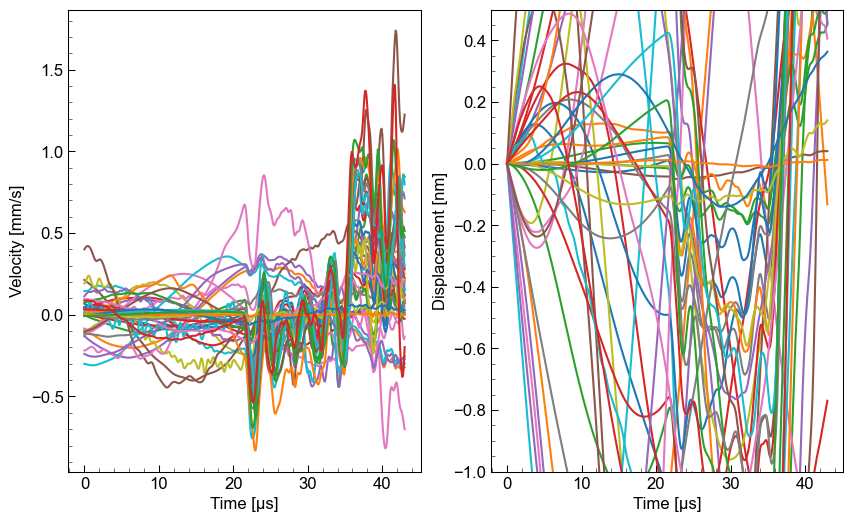

In [186]:
st_repeat_Pvel = Stream()
st_repeat_Pdisp = Stream()

fs = st_repeat[0].stats.sampling_rate
pwin_pre = 20e-6 #4e-6 #10e-6 #3e-6
pwin_len = 20e-6 #10e-6 #6e-6
trim_margin = 1.5e-6

# update: we use the datapoints instead of trim function
pwin_pre_k = int(pwin_pre*fs)
pwin_len_k = int(pwin_len*fs)
trim_margin_k = int(trim_margin*fs)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# freqmin = 0.1e6

for i, datacase in enumerate(datacases):
    gougeevent_id = int(datacase.split("__")[1])
    tr_ind = [x.stats.dataindex[6:] for x in st_repeat].index(datacase)
    tr_obs = st_repeat[tr_ind].copy()
    
    # 1.correct aperture effect
    tr_obs.data /= df_trimP_coef_event["beta_coef_p"]
    
    # 2.apply highpass filter     
    # NOT using sos to minimize the numerical error of filter
    # sos = signal.butter(butterworth_order, freqmin, 'highpass', fs=tr_obs.stats.sampling_rate, output='sos')
    # We use b and a with the Gustafsson method
    b, a = signal.butter(butterworth_order, freqmin, 'highpass', fs=tr_obs.stats.sampling_rate, output='ba')

    # Cheby2 was similar performance with the butter
    # b, a = signal.cheby2(6, 40, freqmin, btype='high', fs=tr_obs.stats.sampling_rate, output='ba')

    # UPDATE: not applying the filter in this notebook. 
    #We will make an option to apply either the detrend or the high-pass filter.
    tr_obs_filtered = tr_obs.copy()

    
    # tr_obs_filtered = tr_obs.copy().taper(0.05)
    # tr_obs_filtered.data = signal.sosfilt(sos, tr_obs_filtered.data)
    # UPDATE: two-way filtering to better retrieve the STF
    # # SKIP; apply high-pass filter to remove low-frequency components, which does not affect the source characteristics
    # tr_obs_filtered.data = signal.sosfiltfilt(sos, tr_obs_filtered.data)
    # tr_obs_filtered.data = signal.filtfilt(b, a, tr_obs_filtered.data, method='gust')
    
    # 3.trim the p wave window
    # we use the datapoints instead of trim function
    onset_k = df_onset.loc[datacase]["onset_npt"]
    tr_obs_retrimmed_p = tr_obs_filtered.copy()
    tr_obs_retrimmed_p.data = tr_obs_filtered.copy().data[onset_k-pwin_pre_k-trim_margin_k:onset_k+pwin_len_k+trim_margin_k+1]

  
    # # # remove offset by first 1us 
    # offset_inds = range(int(1e-6 * tr_obs_retrimmed_p.stats.sampling_rate))
    # tr_obs_retrimmed_p.data -= np.mean(tr_obs_retrimmed_p.data[offset_inds])
    
    st_repeat_Pvel.append(tr_obs_retrimmed_p)

    # 4.Integrate
    tr_obs_retrimmed_p_disp = tr_obs_retrimmed_p.copy().integrate(method='cumtrapz')
    
    # Detrend the linear term
#     tr_obs_retrimmed_p_disp.detrend(type='linear') # skip at this stage. Revisit when computing STF

    # 5.Append to stream
    st_repeat_Pdisp.append(tr_obs_retrimmed_p_disp)

    # axs[0].plot(tr_obs_retrimmed_p.times()*1e6, tr_obs_retrimmed_p.copy().detrend().data*1e3, "-")
    # axs[1].plot(tr_obs_retrimmed_p_disp.times()*1e6, tr_obs_retrimmed_p_disp.copy().detrend().data*1e9, "-")
    axs[0].plot(tr_obs_retrimmed_p.times()*1e6, tr_obs_retrimmed_p.data*1e3, "-")
    axs[1].plot(tr_obs_retrimmed_p_disp.times()*1e6, tr_obs_retrimmed_p_disp.data*1e9, "-")


axs[0].set_xlabel("Time [μs]")
axs[0].set_ylabel("Velocity [mm/s]")
axs[1].set_xlabel("Time [μs]")
axs[1].set_ylabel("Displacement [nm]")

axs[1].set_ylim([-1, 0.5])

(-0.0005, 0.0005)

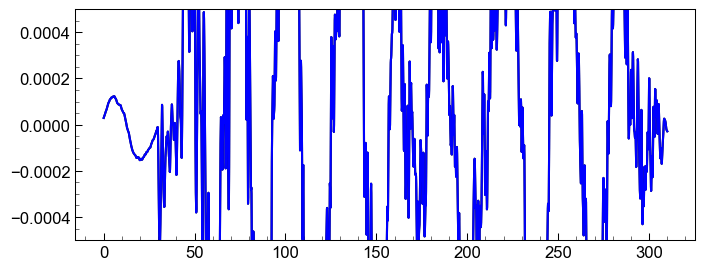

In [187]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(tr_obs.times()*1e6, tr_obs.data, "k-")
ax.plot(tr_obs_filtered.times()*1e6, tr_obs_filtered.data, "b-")
# ax.set_xlim([0, 20])
ax.set_ylim([-.5e-3, .5e-3])

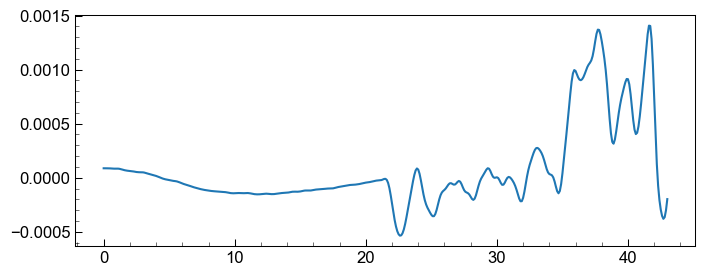

In [188]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(tr_obs_retrimmed_p.times()*1e6, tr_obs_retrimmed_p.data)


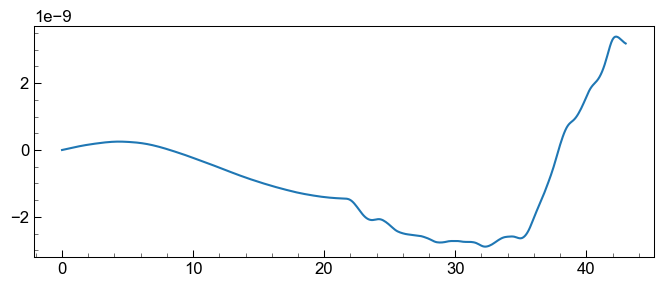

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(tr_obs_retrimmed_p.times()*1e6, tr_obs_retrimmed_p_disp.data)


## Dump the P wave velocity and displacement pulses

These pulses are used to evaluate the half-maximum amplitude width as a metric of source duration with and without Q correction.

In [190]:
st_repeat_Pvel.write(dataoutdir+f"/st_repeat_Pvel_{gougepatch_id}_{repeated_sensor}.pickle", format="PICKLE") 
st_repeat_Pdisp.write(dataoutdir+f"/st_repeat_Pdisp_{gougepatch_id}_{repeated_sensor}.pickle", format="PICKLE") 


## Check the traces

In [191]:
# Plot displacement waveform
datacase_1 = 'fb03-087__0062'
tr_ind = [x.stats.dataindex[6:] for x in st_repeat_Pdisp].index(datacase_1)
tr_obs = st_repeat[tr_ind].copy()

sos = signal.butter(butterworth_order, freqmin, 'highpass', fs=tr_obs.stats.sampling_rate, output='sos')
tr_obs_raw_disp = tr_obs.copy().integrate(method='cumtrapz').copy()
tr_obs_filtered = tr_obs.copy().taper(0.05).copy()
# tr_obs_filtered.data = signal.sosfilt(sos, tr_obs_filtered.data).copy()
tr_obs_filtered.data = signal.sosfiltfilt(sos, tr_obs_filtered.data).copy()
tr_obs_filtered_disp = tr_obs_filtered.copy().integrate(method='cumtrapz').copy()


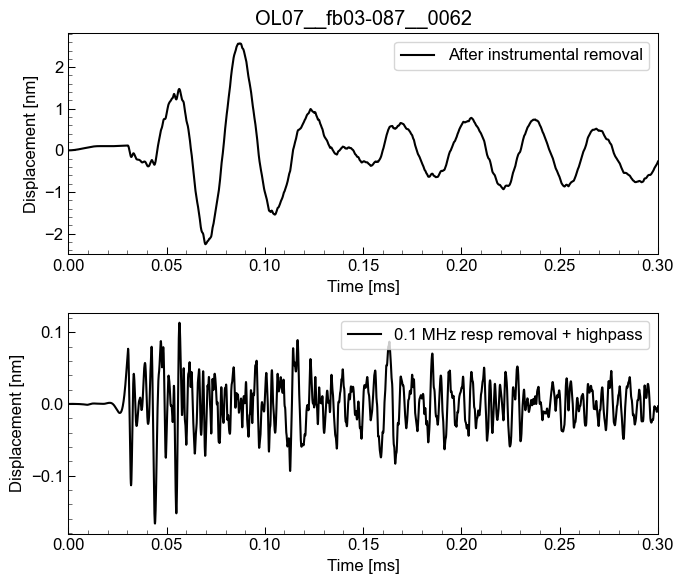

In [192]:
fig, [ax, ax2]= plt.subplots(2, 1, figsize=(7, 6))

ax.plot(tr_obs_raw_disp.times()*1e3, tr_obs_raw_disp.data*1e9, "k-", label="After instrumental removal")
ax.set_title(tr_obs_filtered_disp.stats.dataindex)
ax.set_xlabel("Time [ms]")  
ax.set_ylabel("Displacement [nm]")  
ax.set_xlim([0, 0.3])
# ax.set_ylim([-2.2, 2.2])
ax.legend(loc=1)

ax2.plot(tr_obs_filtered_disp.times()*1e3, tr_obs_filtered_disp.data*1e9, "k-", label=f"{freqmin/1e6:g} MHz resp removal + highpass")
# ax2.set_title(tr_obs_filtered_disp.stats.dataindex)
ax2.set_xlabel("Time [ms]")  
ax2.set_ylabel("Displacement [nm]")
ax2.set_xlim([0, 0.3])
# ax2.set_ylim([-2.2, 2.2])
ax2.legend(loc=1)

fig.tight_layout()

plt.savefig(figdir + "/debug_displacementpulse_demo_{}_{}.png".format(gougepatch_id, repeated_sensor), dpi=300)


# Conclusion

This notebook performed the trimming of P wave pulse and convert it from velocity to displacement. We also computed the radiation pattern coefficient to convert from displacement to $M_0$, which is evaluated for each gouge event. We use these displacement pulses to estimate the HMPW and the moment-duration scaling.